# IP Project

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import numpy as np

plt.rcParams["figure.figsize"]=15,10 #Set plot size
plt.rcParams.update({'font.size': 16}) #set plot size font
plt.rcParams.update({"axes.grid" : True, "grid.color": "lightgrey"}) #Add grid lines to plot

### Black Box

### Other Functions

In [2]:
def Knots(MS):
    return MS / 0.5144

def MS(Knots):
    return Knots * 0.5144

#### Aircraft Parameters

In [3]:
mass = 79000
AbortSpeed = 120 #In Knots

T1 = 106.8 * 1000 #Engine Thrust A320-200 with 2* CFM International LEAP 1A at T/O power (106.80 kN)    ~~TBC~~
T2 = 106.8 * 1000

Decel = 6 #Deceleration of Max Brakes 6ms-2  ~~TBC~~

#### Other Parameters

In [4]:
g = 9.81


In [5]:
V = 0
t = 0
t_step = 1e-3

## Ground Roll

Accelerating along Runway with CONSTANT Thrust


In [6]:
L = 0  # Ground Roll (Zero Lift) {for now}
D_i = 0  # Zero Lift -> Drag = 0   {for now}

mu = 0  # Zero Friction {for now}

W = 9.81 * mass

D_f = mu * (L - W)    #Friction Drag


# N2 : F = m a
#    : F = m dV/dt

def dV(V,t):
    return (T1 + T2 - D_i - D_f)/mass


### Dual Engine Fail @ same time

#### Fuel Cut Condition

In [7]:
a,n,b,c,d,e,f,x0,x1 = [-5,3.25,-0.068,1.249,2.419,0.291,-0.108,0.25,5.5]

def FuelCut(x,a,n,b,c,d,e,f,x0,x1):
    conds = [x<x0, (x>=x0) & (x<x1),x>=x1]
    funcs = [lambda x:1+a*x**n,lambda x:(b/x) + c*np.exp(-d*x) + e/np.sqrt(x) + f, lambda x:0]
    return np.piecewise(x,condlist=conds,funclist=funcs)

In [8]:
t = np.linspace(25,35,101)
t_a=25
FC_T1 = T1 * FuelCut(t-t_a,a,n,b,c,d,e,f,x0,x1)

#for i in t:
 #   print(i,T1 * FuelCut(i-t_a,a,n,b,c,d,e,f,x0,x1))
    
Acc = (T1 * FuelCut(t-t_a,a,n,b,c,d,e,f,x0,x1) + T2 * FuelCut(t-t_a,a,n,b,c,d,e,f,x0,x1) - D_i - D_f)/mass - Decel
Acc

array([-3.29620253, -3.30380482, -3.36852807, -3.83392754, -4.2243518 ,
       -4.53948751, -4.79163382, -4.99317538, -5.15452867, -5.2840769 ,
       -5.38847072, -5.47295912, -5.54167762, -5.59788335, -5.64414243,
       -5.68247792, -5.71448606, -5.74142762, -5.76429954, -5.7838911 ,
       -5.80082812, -5.81560759, -5.82862486, -5.84019511, -5.85057015,
       -5.85995167, -5.86850168, -5.87635073, -5.88360439, -5.89034836,
       -5.89665253, -5.90257414, -5.90816034, -5.91345017, -5.91847614,
       -5.92326552, -5.92784132, -5.93222307, -5.9364275 , -5.94046903,
       -5.94436017, -5.94811184, -5.95173366, -5.95523416, -5.95862094,
       -5.9619008 , -5.9650799 , -5.9681638 , -5.97115758, -5.97406588,
       -5.97689298, -5.97964281, -5.982319  , -5.98492495, -5.98746379,
       -6.        , -6.        , -6.        , -6.        , -6.        ,
       -6.        , -6.        , -6.        , -6.        , -6.        ,
       -6.        , -6.        , -6.        , -6.        , -6.  

Wall time: 54.9 ms


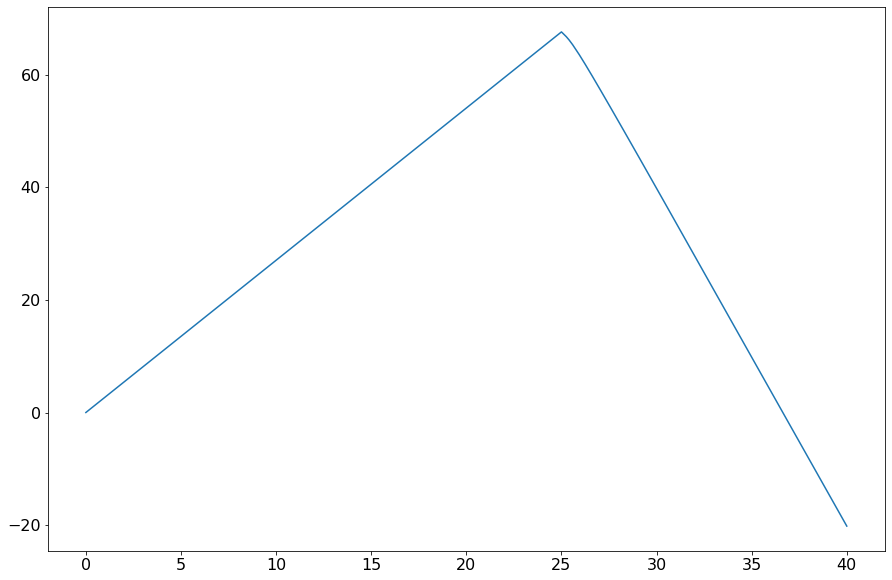

In [9]:
%%time

def dV(t,V,t_a):
    if t <= t_a:
        return (T1 + T2 - D_i - D_f)/mass
    else:
        return (T1 * FuelCut(t-t_a,a,n,b,c,d,e,f,x0,x1) + T2 * FuelCut(t-t_a,a,n,b,c,d,e,f,x0,x1) - D_i - D_f)/mass - Decel

V = solve_ivp(dV,[0,40],[0],args = [25],rtol=1e-9)

plt.plot(V.t,V.y[0])
plt.grid()

Wall time: 19.9 ms


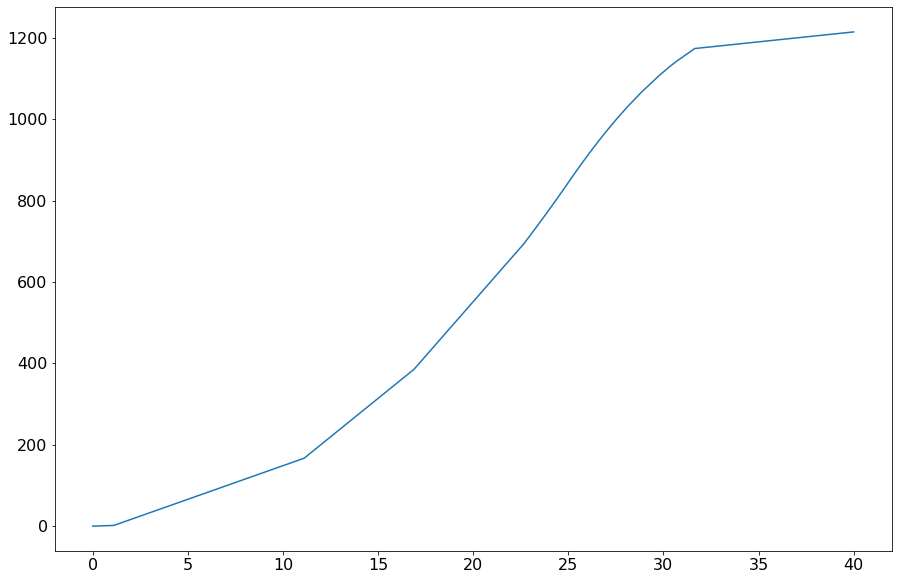

In [10]:
%%time

def dV(t,V,t_a):
    if t <= t_a:
        return (T1 + T2 - D_i - D_f)/mass
    else:
        return (T1 * p(t-t_a) + T2 * p(t-t_a) - D_i - D_f)/mass - Decel

    
def p(t):
    if t < 0.25:
        return 1 -5*t**3.25
    elif t < 5.5:
        return (-0.068/t) + 1.249*np.exp(-2.419*t) + 0.291/np.sqrt(t) - 0.108
    else:
        return 0
    
def f(t,y,a):
    S = y[0]              # extract r from array y
    V = y[1]              # extract v from array y 
    dSdt = V              # compute right hand side
    dVdt = dV(t,V,a)
    return np.array([dSdt, dVdt]) # return array


# initial conditions
s0 = 0 # initial s
v0 = 0 # initial v

# combine s and v into array y0
y0 = np.array([s0, v0])

S = solve_ivp(f,[0,40],y0,args = [25],rtol=1e-9)

plt.plot(S.t,S.y[0])
plt.grid()

Wall time: 2.87 s


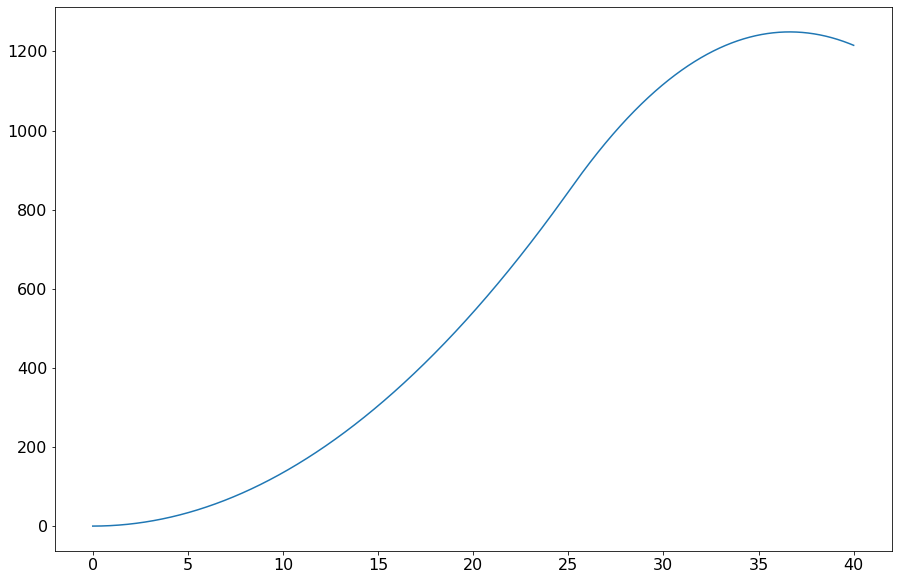

In [11]:
%%time

def dV(t,V,t_a):
    if t <= t_a:
        return (T1 + T2 - D_i - D_f)/mass
    else:
        return (T1 * p(t-t_a) + T2 * p(t-t_a) - D_i - D_f)/mass - Decel

def f(t,y,a):
    S = y[0]              # extract r from array y
    V = y[1]              # extract v from array y 
    dSdt = V              # compute right hand side
    dVdt = dV(t,V,a)
    return np.array([dSdt, dVdt]) # return array


# initial conditions
s0 = 0 # initial s
v0 = 0 # initial v

# combine s and v into array y0
y0 = np.array([s0, v0])

S = solve_ivp(f,[0,40],y0,args = [25],rtol=1e-9,max_step=1e-3)

plt.plot(S.t,S.y[0])
plt.grid()

In [12]:
print('Run stopped at {:.6f}'.format(S.t[-1]))
print('Run length     {:.6f}'.format(S.y[0][-1]))

Run stopped at 40.000000
Run length     1215.423754


#### Throttle Chop Condition

In [13]:
a,b,c,d,e,x0,x1 = [-0.261,1.280,1.345,0.612,-0.073,0.39,12]

def ThrottleChop(x,a,b,c,d,e,x0,x1):
    conds = [x<x0, (x>=x0) & (x<x1),x>=x1]
    funcs = [1,lambda x:(a/x) + b*np.exp(-c*x) + d/np.sqrt(x) + e, (a/x1) + b*np.exp(-c*x1) + d/np.sqrt(x1) + e]
    return np.piecewise(x,condlist=conds,funclist=funcs)

In [14]:
t = np.linspace(25,40,101)
t_a=25
TC_T1 = T1 * ThrottleChop(t-t_a,a,b,c,d,e,x0,x1)

for i in t:
    print(i,T1 * ThrottleChop(i-t_a,a,b,c,d,e,x0,x1))
    
Acc = (T1 * ThrottleChop(t-t_a,a,b,c,d,e,x0,x1) + T2 * ThrottleChop(t-t_a,a,b,c,d,e,x0,x1) - D_i - D_f)/mass - Decel
Acc

25.0 106800.0
25.15 106800.0
25.3 106800.0
25.45 102326.81859115245
25.6 91123.65541300058
25.75 80362.74274670382
25.9 70873.15943910627
26.05 62742.91486726938
26.2 55857.65748564432
26.35 50053.812749722485
26.5 45167.84867169396
26.65 41052.15767125347
26.8 37579.0511677031
26.95 34640.35566136895
27.1 32145.46027995537
27.25 30018.95602221198
27.4 28198.325853793584
27.55 26631.85885241992
27.7 25276.838262917314
27.85 24098.000459626957
28.0 23066.240568856727
28.15 22157.533668683118
28.3 21352.04014683407
28.45 20633.366231907
28.6 19987.95414445646
28.75 19404.579906757597
28.9 18873.94022718783
29.05 18388.312887815693
29.2 17941.27767347954
29.35 17527.48710127218
29.5 17142.478077390777
29.65 16782.517167767168
29.8 16444.473463910974
29.95 16125.71409683808
30.1 15824.018336073117
30.25 15537.506938849232
30.4 15264.584013450954
30.55 15003.889152606484
30.7 14754.257996687633
30.85 14514.689717808838
31.0 14284.320187637639
31.15 14062.3998144943
31.3 13848.275217910212
3

array([-3.29620253, -3.29620253, -3.29620253, -3.40944763, -3.69307201,
       -3.96550018, -4.2057428 , -4.41157178, -4.58588209, -4.73281487,
       -4.85651016, -4.96070487, -5.04863162, -5.12302897, -5.18619088,
       -5.24002643, -5.28611833, -5.32577573, -5.36008004, -5.38992404,
       -5.41604454, -5.43904978, -5.45944202, -5.4776363 , -5.49397584,
       -5.50874481, -5.52217873, -5.53447309, -5.54579044, -5.55626615,
       -5.56601321, -5.57512615, -5.58368422, -5.59175407, -5.59939194,
       -5.60664539, -5.61355484, -5.6201547 , -5.62647448, -5.6325395 ,
       -5.63837164, -5.64398988, -5.64941075, -5.65464876, -5.65971665,
       -5.66462571, -5.66938598, -5.67400643, -5.67849512, -5.68285931,
       -5.68710562, -5.69124002, -5.69526802, -5.69919466, -5.70302458,
       -5.70676207, -5.71041112, -5.71397544, -5.71745848, -5.7208635 ,
       -5.72419351, -5.72745139, -5.7306398 , -5.7337613 , -5.73681828,
       -5.739813  , -5.74274762, -5.74562417, -5.74844461, -5.75

Wall time: 35.9 ms


Text(0.5, 0, 'Time [s]')

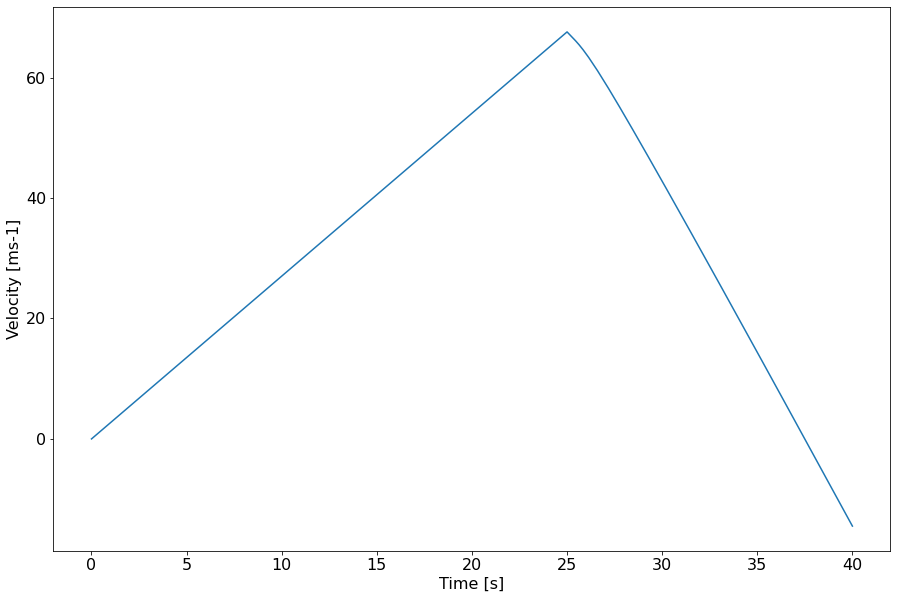

In [22]:
%%time

def dV(t,V,t_a):
    if t <= t_a:
        return (T1 + T2 - D_i - D_f)/mass
    else:
        return (T1 * ThrottleChop(t-t_a,a,b,c,d,e,x0,x1) + T2 * ThrottleChop(t-t_a,a,b,c,d,e,x0,x1) - D_i - D_f)/mass - Decel

V = solve_ivp(dV,[0,40],[0],args = [25],rtol=1e-9)

plt.plot(V.t,V.y[0])
plt.grid()
plt.ylabel('Velocity [ms-1]')
plt.xlabel('Time [s]')

Wall time: 36.9 ms


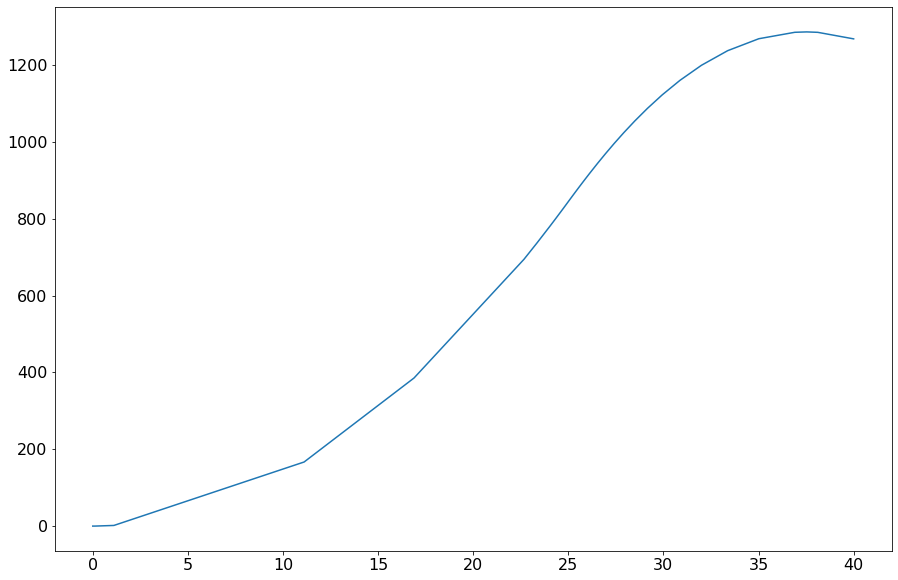

In [16]:
%%time

def dV(t,V,t_a):
    if t <= t_a:
        return (T1 + T2 - D_i - D_f)/mass
    else:
        return (T1 * ThrottleChop(t-t_a,a,b,c,d,e,x0,x1) + T2 * ThrottleChop(t-t_a,a,b,c,d,e,x0,x1) - D_i - D_f)/mass - Decel

    
#def p(t):
#    if t < 0.25:
#        return 1 -5*t**3.25
#    elif t < 5.5:
#        return (-0.068/t) + 1.249*np.exp(-2.419*t) + 0.291/np.sqrt(t) - 0.108
#    else:
#        return 0
    
def f(t,y,a):
    S = y[0]              # extract r from array y
    V = y[1]              # extract v from array y 
    dSdt = V              # compute right hand side
    dVdt = dV(t,V,a)
    return np.array([dSdt, dVdt]) # return array


# initial conditions
s0 = 0 # initial s
v0 = 0 # initial v

# combine s and v into array y0
y0 = np.array([s0, v0])

S = solve_ivp(f,[0,40],y0,args = [25],rtol=1e-9)

plt.plot(S.t,S.y[0])
plt.grid()

Wall time: 7.51 s


Text(0.5, 0, 'Time [s]')

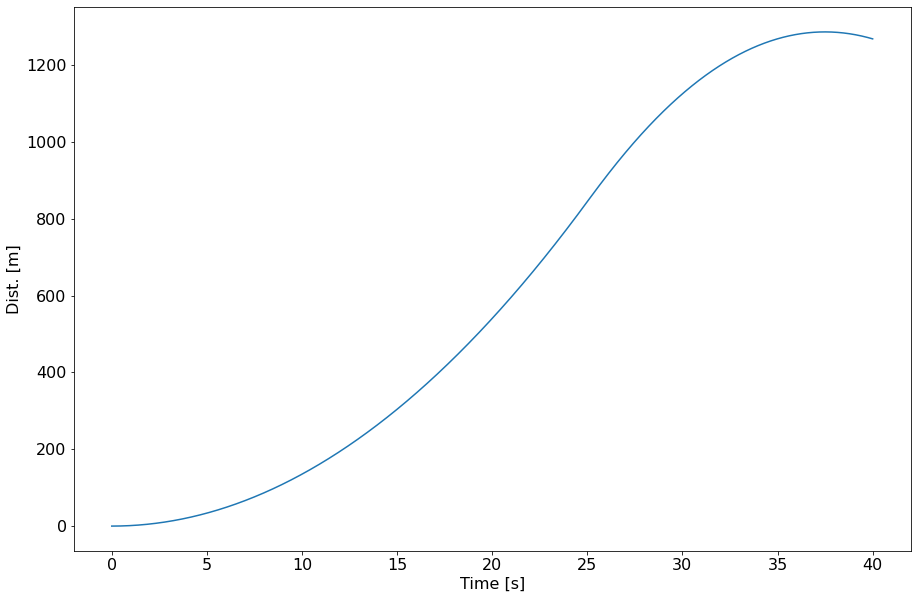

In [21]:
%%time

def dV(t,V,t_a):
    if t <= t_a:
        return (T1 + T2 - D_i - D_f)/mass
    else:
        return (T1 * ThrottleChop(t-t_a,a,b,c,d,e,x0,x1) + T2 * ThrottleChop(t-t_a,a,b,c,d,e,x0,x1) - D_i - D_f)/mass - Decel
    
def f(t,y,a):
    S = y[0]              
    V = y[1]               
    dSdt = V              
    dVdt = dV(t,V,a)
    return np.array([dSdt, dVdt]) 


# initial conditions
s0 = 0 # initial s
v0 = 0 # initial v

# combine s and v into array y0
y0 = np.array([s0, v0])

S = solve_ivp(f,[0,40],y0,args = [25],rtol=1e-9,max_step=1e-3)

plt.plot(S.t,S.y[0])
plt.grid()
plt.ylabel('Dist. [m]')
plt.xlabel('Time [s]')

In [20]:
print('Run stopped at {:.6f}'.format(S.t[-1]))
print('Run length     {:.6f}'.format(S.y[0][-1]))

print('Run length     {:.6f}'.format(max(S.y[0])))

Run stopped at 40.000000
Run length     1268.704553
Run length     1286.835256
